In [1]:
import pyRing

### Damped Sinusoids

In [2]:
from pyRing import waveform as wf
#wf.Damped_sinusoids?

/home/sreelakshmi.m/softwares/anaconda3/envs/igwn-py310/lib/python3.10/site-packages/pyRing/utils.py:60: UserWarning: * The `surfinBH` package is not automatically installed due to possible conflicts. If you wish to use its functionalities, it needs to be installed separately.
  warnings.warn("* The `surfinBH` package is not automatically installed due to possible conflicts. If you wish to use its functionalities, it needs to be installed separately.")


In [18]:
from pyRing import waveform as wf
A = {'t': (1e-20,0.2*1e-20,0.3*1e-20,0.4*1e-20,0.5*1e-20)}
f = {'t': (220,230,250,240,260)}
tau={'t': (0.001,0.002,0.0005,0.001,0.0015)}
phi={'t': (0,0,0,0,0)}
t={'t': (0.0033, 0.0033, 0.0033,0.0033,0.0033)}
parameters = {
        'A': A,    # Amplitude
        'f': f,    # Frequency
        'tau': tau,  # Damping time constant
        'phi': phi,  # Phase
        't0': t    # Time
    }



DS = wf.Damped_sinusoids(**parameters)

In [19]:
from pyRing import waveform as wf
import numpy as np
time_array = np.arange(0.0033,0.02,2e-4 )
print(type(time_array))

check = DS.waveform(time_array)
# wf.Damped_sinusoids.waveform(time_array)


<class 'numpy.ndarray'>


84


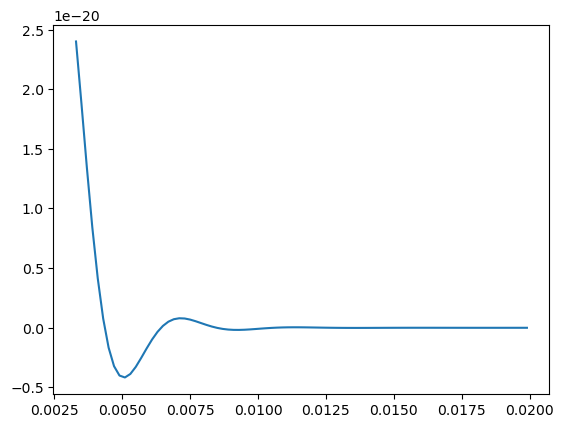

In [23]:
print(len(time_array))
check.shape
hp= (check[3])
hc= check[4]
import matplotlib.pyplot as plt
plt.plot(time_array,hp)
plt.savefig('damped_sinusoids.png', bbox_inches='tight')

/home/sreelakshmi.m/softwares/anaconda3/envs/igwn-py310/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


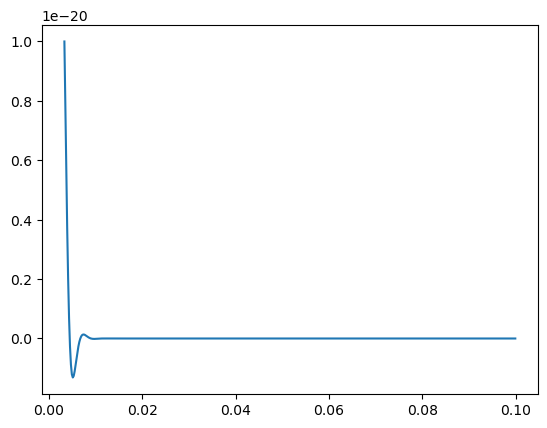

In [8]:
time_array = np.arange(0.0033,0.1,2e-4 )
waveform_model=wf.damped_sinusoid(1e-20,220,0.001,0,0.0033,time_array)
#print(waveform_model)
plt.plot(time_array,waveform_model)

### KerrBH

In [9]:
wf.KerrBH?

Init signature: wf.KerrBH(self, /, *args, **kwargs)
Docstring:     
| Multi mode ringdown model for a Kerr black hole using predictions of the frequencies and damping times as function of mass and spin, as predicted by perturbation theory.
|
| [Input parameters]
|
| t0    : Start time of the ringdown, currently common for all modes. #IMPROVEME: allow for a different start time for each mode.
| Mf    : Final mass in solar masses.
| af    : Dimensionless final spin.
| amps  : Amplitudes of the (s,l,m,n) modes. Expected syntax: amps[(s,l,m,n)] = `value`. The keys of this dictionary set the modes used in the waveform.
| r     : Distance in Mpc.
| iota  : Inclination in radians.
| phi   : Azimuthal angle in radians.
|
| [Optional parameters]
|
| [[Units and spectrum]]
|
| reference_amplitude : If non-zero, value with which to replace the Mf/r prefactor. Default: 0.0.
| geom                : Flag to compute only the h_{l,m} modes, without spherical harmonics. Default: 0.
| qnm_fit           

In [42]:

t0 = 0.0033   
Mf = 64
af = 0.68   
amps = {(2,2,2,0): (5,5)}
r = 470
iota = np.pi/4
phi  = np.pi/4

Kerr = wf.KerrBH(t0,Mf,af,amps,r,iota,phi)


In [43]:
for (s,l,m,n),a in amps.items():
    print(a)

(5, 5)


In [44]:
time_array = np.arange(0.0033, 0.05, 2e-4)
#print(time_array)
check_kerr = Kerr.waveform(time_array)
#print(check_kerr)
check_kerr.shape
hp=check_kerr[3]
hc=check_kerr[4]
#print(hp)

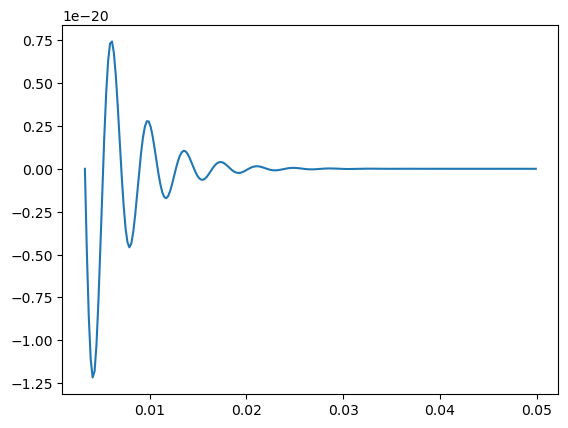

In [45]:
plt.plot(time_array,hp)


In [14]:
import pycbc
def wf_len_mod_start(wf, extra=1, **prms):
    """
    Function to modify the starting of a WF so that it starts on an integer GPS time (in sec) + add extra length as specified by the user.

    Parameters
    ----------
    wf :  pycbc.types.TimeSeries
        WF whose length is to be modified.
    extra : int, optional
        Extra length to be added in the beginning after making the WF to start from an integer GPS time (in sec). Default = 1.

    Returns
    -------
    pycbc.types.timeseries.TimeSeries
        Modified waveform starting form an integer time.

    """      

    sr = prms['sample_rate']
    olen = len(wf)   
    diff = wf.sample_times[0]-np.floor(wf.sample_times[0])  
    #nlen = round(olen+sr*(extra+diff))
    dlen = round(sr*(extra+diff))
    wf_strain = np.concatenate((np.zeros(dlen), wf))
    t0 = wf.sample_times[0]
    dt = wf.delta_t
    n = dlen
    tnn = t0-(n+1)*dt
    wf_stime = np.concatenate((np.arange(t0-dt,tnn,-dt)[::-1], np.array(wf.sample_times)))
    nwf = pycbc.types.TimeSeries(wf_strain, delta_t=wf.delta_t, epoch=wf_stime[0])
    return nwf

In [15]:
from pycbc.types import TimeSeries

In [16]:
hp = TimeSeries(hp, delta_t=time_array[1]-time_array[0])
hc = TimeSeries(hc, delta_t=time_array[1]-time_array[0])

In [17]:
hp_ = wf_len_mod_start(hp, extra=0.2, **{'sample_rate':hp.sample_rate})
hc_ = wf_len_mod_start(hc, extra=0.2, **{'sample_rate':hp.sample_rate})

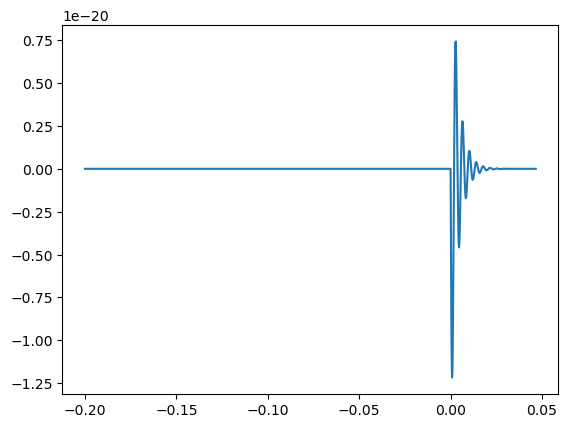

In [18]:
plt.plot(hp_.sample_times, hp_)

In [19]:
def _len_guards(M):
    """
    Handle small or incorrect window lengths
    """
    if int(M) != M or M < 0:
        raise ValueError('Window length M must be a non-negative integer')
    return M <= 1

def _extend(M, sym):
    """
    Extend window by 1 sample if needed for DFT-even symmetry
    """
    if not sym:
        return M + 1, True
    else:
        return M, False
    
def _truncate(w, needed):
    """
    Truncate window by 1 sample if needed for DFT-even symmetry
    """
    if needed:
        return w[:-1]
    else:
        return w

def general_cosine_start(M, a, sym=True):
    """
    Generic weighted sum of cosine terms window
    """
    if _len_guards(M):
        return np.ones(M)
    M, needs_trunc = _extend(M, sym)

    fac_ = np.linspace(-np.pi, 0, M // 2)
    padding = M - (M //2)
    fac = np.pad(fac_, (0, padding), 'constant')
    w = np.zeros(M)
    for k in range(len(a)):
        w += a[k] * np.cos(k * fac)

    return _truncate(w, needs_trunc)

def general_cosine_end(M, a, sym=True):
    """
    Generic weighted sum of cosine terms window
    """
    if _len_guards(M):
        return np.ones(M)
    M, needs_trunc = _extend(M, sym)

    fac_ = np.linspace(0, np.pi, M // 2)
    padding = M - (M //2)
    fac = np.pad(fac_, (padding, 0), 'constant')
    w = np.zeros(M)
    for k in range(len(a)):
        w += a[k] * np.cos(k * fac)

    return _truncate(w, needs_trunc)

def half_tukey_start(M, alpha=0.5, sym=True):
    """
    Return a half Tukey window, also known as a tapered cosine window.
    """
    if _len_guards(M):
        return np.ones(M)

    if alpha <= 0:
        return np.ones(M, 'd')
    elif alpha >= 1.0:
        return general_cosine_start(M, [0.5, 0.5], sym)

    M, needs_trunc = _extend(M, sym)

    n = np.arange(0, M)
    width = int(np.floor(alpha*(M-1)/2.0))
    n1 = n[0:width+1]
    n2 = n[width+1:]

    w1 = 0.5 * (1 + np.cos(np.pi * (-1 + 2.0*n1/alpha/(M-1))))
    w2 = np.ones(n2.shape)

    w = np.concatenate((w1, w2))

    return _truncate(w, needs_trunc)

def half_tukey_end(M, alpha=0.5, sym=True):
    """
    Return a half Tukey window, also known as a tapered cosine window.
    """
    if _len_guards(M):
        return np.ones(M)

    if alpha <= 0:
        return np.ones(M, 'd')
    elif alpha >= 1.0:
        return general_cosine_end(M, [0.5, 0.5], sym)

    M, needs_trunc = _extend(M, sym)

    n = np.arange(0, M)
    width = int(np.floor(alpha*(M-1)/2.0))
    n1 = n[0:M-width-1]
    n2 = n[M-width-1:]

    w1 = np.ones(n1.shape)
    w2 = 0.5 * (1 + np.cos(np.pi * (-2.0/alpha + 1 + 2.0*n2/alpha/(M-1))))

    w = np.concatenate((w1, w2))

    return _truncate(w, needs_trunc)

def time_domain_window(t, hp, type = 'STARTEND', roll_off=None, alpha=None):
        """
        Window function to apply to time domain data before FFTing.

        This defines self.window_factor as the power loss due to the windowing.
        See https://dcc.ligo.org/DocDB/0027/T040089/000/T040089-00.pdf

        Parameters
        ==========
        roll_off: float
            Rise time of window in seconds
        alpha: float
            Parameter to pass to tukey window, how much of segment falls
            into windowed part

        Returns
        =======
        window: array
            Window function over time array
        """
        from scipy.signal.windows import tukey
        if roll_off is not None:
            alpha = 2 * roll_off / t[-1]
        elif alpha is not None:
            roll_off = alpha * t[-1] / 2
        if type == 'STARTEND':
            window = tukey(len(hp), alpha=alpha)
        elif type == 'START':
            window = half_tukey_start(len(hp), alpha=alpha)
        elif type == 'END':
            window = half_tukey_end(len(hp), alpha=alpha)
        else:
            raise ValueError("type must be START, END or STARTEND")

        window_factor = np.mean(window ** 2)
        return window, window_factor

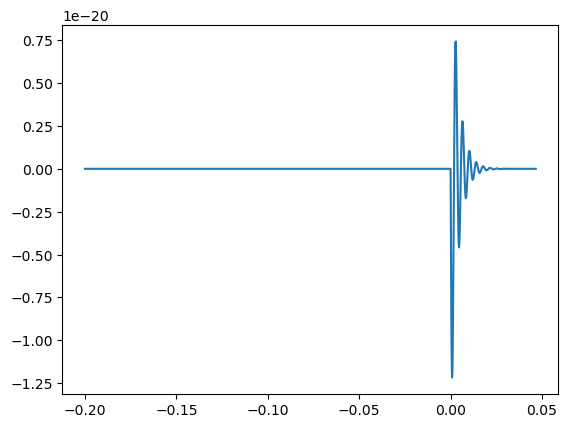

In [20]:
#Tapering
window = time_domain_window(time_array, hp_, type = 'START', roll_off=0.003, alpha=None)
hp_tapered = window[0]*hp_
plt.plot(hp_tapered.sample_times, hp_tapered)

In [69]:
f_hp = hp_.to_frequencyseries(delta_f=hp_.delta_f)


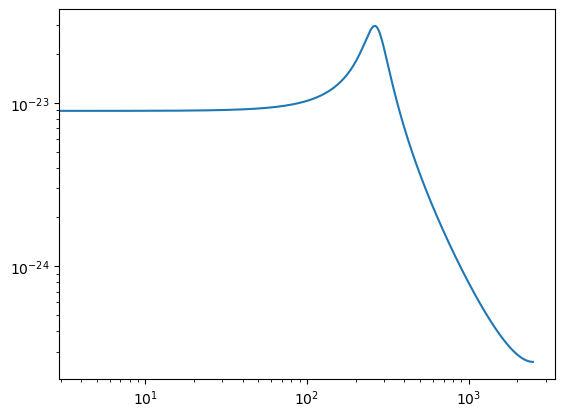

In [22]:
### padded 
plt.loglog(f_hp.sample_frequencies, np.abs(f_hp))
plt.show()

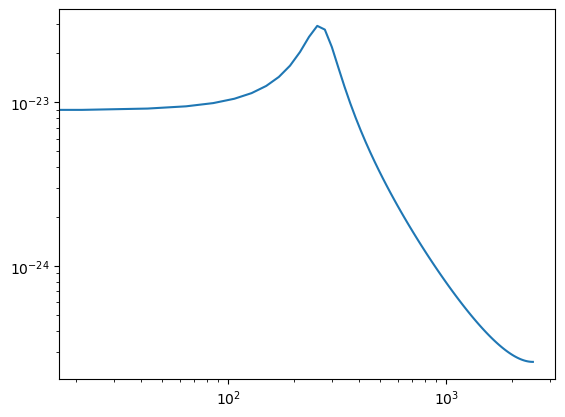

In [23]:
##not padded
fd_hp=hp.to_frequencyseries(delta_f=hp.delta_f)
plt.loglog(fd_hp.sample_frequencies, np.abs(fd_hp))

In [24]:
##normal fft
frequency = np.fft.fftfreq(len(time_array),0.0002)
fft_hp = np.fft.fft(hp)
fft_hp_taper = np.fft.fft(hp_tapered)
#fft_hc = np.fft.fft(hc)

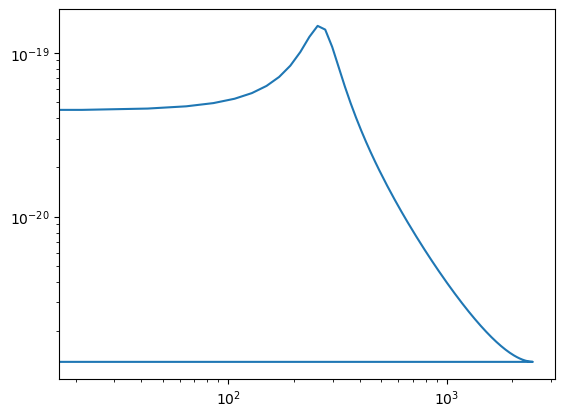

In [55]:
###normal fft
#plt.plot(frequency,np.abs(fft_hp))
import pylab
#plt.ylim(1e-21,1e-18)
pylab.loglog(frequency, np.abs(fft_hp))
#pylab.loglog(frequency, np.abs(fft_hp_tapered))
plt.show()

In [66]:
pip install pykerr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 MB 3.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 6.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.2
    Uninstalling numpy-1.26.2:
      Successfully uninstalled numpy-1.26.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cdsutils 1.6.0 requires nds2-client, which is not installed.
cdsutils 1.6.0 requires python-ezca, which is not installed.
sxs 2022.5.1 requires caltechdata-api>=0.3.0, which is not installed.
sxs 2022.5.1 requires feedparser>=6.0.1, which is not installed.
sxs 2022.5.1 requires pylatexenc>=2.7, which is not installed.
Note: you may need to restart the kernel to use updated packages.


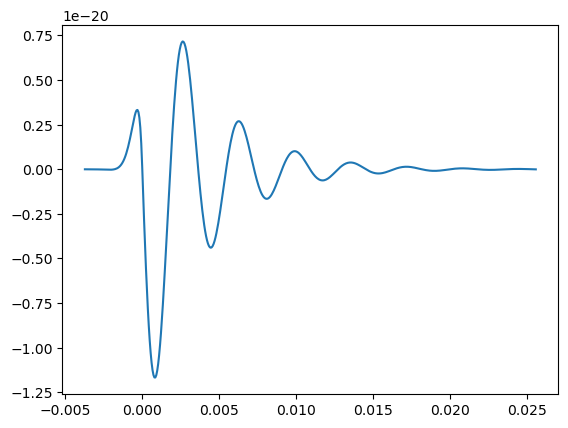

In [56]:
import numpy as np
from pycbc.waveform import ringdown
lmn = ['221']
template_params = {'final_mass' : 61.5, 'final_spin': 0.68, 'distance': 470, 'amp220':5, 'phi220': 0, 'harmonics' : 'spheroidal', 'inclination':np.pi/4, 'azimuthal':np.pi/4,  'taper': True}   
hp_kerr, hc_kerr = ringdown.get_td_from_final_mass_spin(template=template_params, lmns = lmn)
plt.plot(hp_kerr.sample_times,hp_kerr)
plt.show()

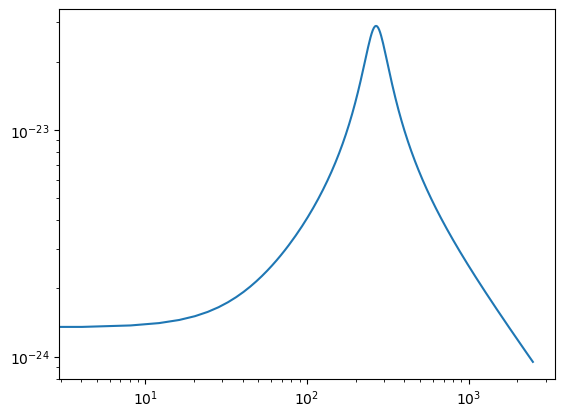

In [33]:
### fd waveform from pycbc
import numpy as np
from pycbc.waveform import ringdown
lmn = ['221']
template_params = {'final_mass' : 64, 'final_spin': 0.68, 'distance': 470, 'ref_amp' :'amp220','amp220':5, 'phi220': 0, 'harmonics' : 'spheroidal', 'inclination':np.pi/4, 'azimuthal':np.pi/4, 'delta_f':hp_.delta_f, 'f_lower':f_hp.sample_frequencies[0], 'f_final':f_hp.sample_frequencies[-1]}   
hfp_kerr, hfc_kerr = ringdown.get_fd_from_final_mass_spin(template=template_params, lmns = lmn)
plt.loglog(hfp_kerr.sample_frequencies, np.abs(hfp_kerr))
plt.show()

In [57]:
### script to add in gwbench
import pyRing
import numpy as np
import pycbc
import scipy
from scipy.interpolate import interp1d
from pycbc.types import TimeSeries
from pyRing import waveform as wf
import sys
sys.path.append('/home/sreelakshmi.m/gwmat/src')
import py_lgw
lgw = py_lgw.lensed_wf_gen()

wf_symbs_string = 'f t0 Mf af A_lmn D_L iota phi tc phic'


def hfpc(f,t0, Mf, af, A_lmn, D_L, iota, phi, tc, phic):
    #f_min   = f[0]
    #delta_f = f[1] - f[0]
    #f_max   = f[-1] + delta_f

    t0 = t0 
    Mf = Mf
    af = af   
    amps = A_lmn
    r = D_L
    iota = iota
    phi  = phi
    
    Kerr = wf.KerrBH(t0,Mf,af,amps,r,iota,phi)
    t= np.arange(0.0033, 0.05, 2e-4)
    waveform = Kerr.waveform(t)
    hp = waveform[3]
    hc = waveform[4]
    hp = TimeSeries(hp, delta_t=t[1]-t[0])
    hc = TimeSeries(hc, delta_t=t[1]-t[0])
    hp_ = lgw.wf_len_mod_start(hp, extra=0.2, **{'sample_rate':hp.sample_rate})
    hc_ = lgw.wf_len_mod_start(hc, extra=0.2, **{'sample_rate':hp.sample_rate})
    f_hp = hp_.to_frequencyseries(delta_f=hp_.delta_f)
    f_hc = hp_.to_frequencyseries(delta_f=hc_.delta_f)
    
    wfs_res = {'hp':f_hp, 'hc':f_hc}
    res = dict()

    frequency_vector = f #Desired frequency vector

    for key in wfs_res.keys():

        temp_fd = wfs_res[key]
        log_strain_array = np.log10(np.array(temp_fd, dtype=np.complex128))
        log_abs = np.real(log_strain_array)
        phase = np.array(pycbc.waveform.utils.phase_from_frequencyseries(temp_fd))
        if_log_abs = interp1d(temp_fd.sample_frequencies[:], log_abs[:], kind='linear')
        if_phase = interp1d(temp_fd.sample_frequencies[:], phase[:], kind='linear')
        interpolated_abs = np.concatenate(([0], 10**(if_log_abs(frequency_vector[1:]))))
        interpolated_phase = np.concatenate(([0], if_phase(frequency_vector[1:])))
        interpolated_strain = interpolated_abs * np.exp(1j * interpolated_phase)
        frequency_bounds = (frequency_vector >= frequency_vector[0]) * (frequency_vector<= frequency_vector[-1])
        interpolated_strain *= frequency_bounds
        assert len(interpolated_strain) == len(f)
        res[key] = interpolated_strain
        hfp = res['hp']
        hfc = res['hc']

    return res['hp'], res['hc']

In [73]:

# t = np.arange(0.0033, 0.05, 2e-4)
# hp_wave = hfpc(t, t0 = 0.0033, Mf = 64, af = 0.68, A_lmn={(2,2,2,0): (5,5)}, D_L=470, iota=np.pi/4, phi=np.pi/4, tc=0, phic=0)
# print(hp_wave[0].shape)
# print(f_hp.sample_frequencies.shape)
# plt.loglog(f_hp.sample_frequencies, np.abs(hp_wave[0]))

#### Injections

In [11]:
from pyRing import inject_signal
A = {'t': (1e-20,0.2*1e-20,0.3*1e-20,0.4*1e-20,0.5*1e-20)}
f = {'t': (220,230,250,240,260)}
tau={'t': (0.001,0.002,0.0005,0.001,0.0015)}
phi={'t': (0,0,0,0,0)}
t={'t': (0.0033, 0.0033, 0.0033,0.0033,0.0033)}
parameters = {'injection-parameters':{'A':A,'f':f, 'tau':tau, 'phi':phi, 't':t}}
x= inject_signal.damped_sinusoids_injection(**parameters)